# # Fine-tune Mistral-7b with supervised learning

# Le but est de entrainer Mistral 7B sur un corpus de donnes pour qu'il soit efficace pour une task specifique


# L'idee c'est que on a un Mistral 7B entraine sur plusieurs millions de données. On garde les poids puis on ajoute notre corpus de texte pour le rendre plus efficace sur une tache specifique ( Dans notre cas les mathematique )

In [ ]:
!nvidia-smi

Fri Apr 12 10:45:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Installer nos dependances
# - transformers datasets accelerate peft trl pour importer le modeln le dataset, utulise pour un fine tuning
# - bitsandbytes pour la partie quantization, decider du format a adopter pour le model
# - wandb avoir des visualisation pendant l'entrainement

In [ ]:
!pip install -qqq -U transformers datasets accelerate peft trl bitsandbytes wandb --progress-bar off


In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    AutoTokenizer,
    TrainingArguments,
    pipeline,
)
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training
from trl import SFTTrainer
from google.colab import userdata
import wandb

# Defined in the secrets tab in Google Colab
hf_token = userdata.get('HF_TOKEN')
wb_token = userdata.get('wandb')
wandb.login(key=wb_token)

base_model = "alpindale/Mistral-7B-v0.2-hf"
new_model = "mistral-7b-mathv0"

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


# On va utulise une fine tuning avec Qlora
# il y'a 3 type de fine tuning - Full Finetuning  ou c'est une technique qui consiste a re entraine tout les poids du model chose qui demande enomement de resources gpu
# - QLora : Une approche ou va plutôt faire une approximation de certaines couches du modèle et rapprocher les paramètres en 4bit. Ca permet d'effectuer un réglage fin sur peu de ressources. Expérimentalement sur le même résultat qu'un full fine tuning

In [ ]:
dataset = load_dataset("microsoft/orca-math-word-problems-200k", split="train")

tokenizer = AutoTokenizer.from_pretrained(base_model, use_fast=True)
tokenizer.pad_token = tokenizer.unk_token

# Configuration entrainement
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, # charge model en 4bit
    bnb_4bit_quant_type="nf4", # format
    bnb_4bit_compute_dtype=torch.float16, # poids en 16bit
    bnb_4bit_use_double_quant=True,
)

peft_config = LoraConfig(
    lora_alpha=32,
    lora_dropout=0.05,
    r=16, # plus r eleve plus approximation est precise du fait plus aura de parametres entrainer
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['up_proj', 'down_proj', 'gate_proj', 'k_proj', 'q_proj', 'v_proj', 'o_proj'] # cibler tout les layers lineaires, c'est recommande
)

model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    device_map={"": 0},
)

model = prepare_model_for_kbit_training(model)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
training_arguments = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3, # entraine 3 fois sur le dataset
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    gradient_accumulation_steps=1,
    evaluation_strategy="steps",
    eval_steps=0.01,
    logging_steps=1,
    optim="paged_adamw_8bit",
    learning_rate=2e-4,
    lr_scheduler_type="linear",
    warmup_steps=10,
    report_to="wandb",
)

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    eval_dataset=dataset.select(range(0,20)),
    peft_config=peft_config,
    dataset_text_field="question",
    max_seq_length=512,
    tokenizer=tokenizer,
    args=training_arguments,
)

trainer.train()

trainer.model.save_pretrained(new_model)
tokenizer.save_pretrained(new_model)

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_re

Step,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 192.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 1.06 MiB is free. Process 7799 has 14.63 GiB memory in use. Of the allocated memory 13.77 GiB is allocated by PyTorch, and 742.82 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# test du model

In [ ]:
prompt = "In a highly contested election having multiple candidates, Mr. Jackson, one of the losing candidates, received 3,485,782 votes, which accounted for precisely 38.7 percent of all votes. To have achieved a victory, he would have needed to secure at least 51 percent of all votes. Approximately, what percent of the remaining unsecured votes would Mr. Jackson have needed to accumulate to reach this victory threshold?"
instruction = f"### Instruction:\n{prompt}\n\n### Response:\n"

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, max_length=128)
result = pipe(instruction)
print(result[0]["generated_text"][len(instruction):])


The answer is 11.3 percent.

### Explanation:



In [ ]:
prompt = "In a school election, there are three candidates: Alice, Bob, and Carol. After counting the votes, Alice received 350 votes, Bob received 420 votes, and Carol received 300 votes. If there are a total of 1,500 votes cast in the election, what percentage of the total votes did Bob receive?"
instruction = f"### Instruction:\n{prompt}\n\n### Response:\n"

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, max_length=128)
result = pipe(instruction)
print(result[0]["generated_text"][len(instruction):])


The total number of votes cast in the election is 1,500. Bob received 420 votes, which is 420 out of 1,500. The


# # Partie 2

# Souvent les DM sont ecrit avec la main ca serait bien pour avoir un  produit complet, faire une ocr qui permet d'extraire le texte ecrit a la maison ainsi que les formules mathematiques pour pouvoir les inere directement au model

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

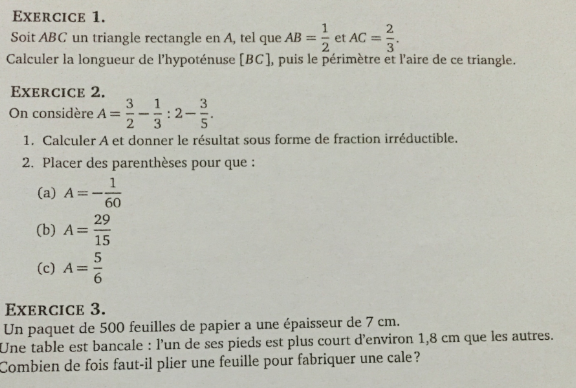

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

exempledm = "mathdm.png"
img = cv2.imread(exempledm)

cv2_imshow(img)



In [ ]:
! pip install transformers>=4.37.0 pillow optimum[onnxruntime]


In [ ]:
from PIL import Image
from transformers import TrOCRProcessor
from optimum.onnxruntime import ORTModelForVision2Seq

processor = TrOCRProcessor.from_pretrained('breezedeus/pix2text-mfr')
model = ORTModelForVision2Seq.from_pretrained('breezedeus/pix2text-mfr', use_cache=False)

image_fps = [
    'mathdm.png',

]
images = [Image.open(fp).convert('RGB') for fp in image_fps]
pixel_values = processor(images=images, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)
print(f'generated_ids: {generated_ids}, \ngenerated text: {generated_text}')



preprocessor_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/39.2k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

encoder_model.onnx:   0%|          | 0.00/87.5M [00:00<?, ?B/s]

decoder_model.onnx:   0%|          | 0.00/30.1M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

generated_ids: tensor([[  2,  64, 422,  95, 412,  97, 262, 323, 261, 262, 262, 263, 346, 262,
         293, 379, 419, 311, 300, 318, 313, 284, 272, 268, 261, 271, 261, 261,
         337, 262, 262, 263, 346, 262, 293, 379, 419, 328, 311, 300, 318, 313,
         284, 272, 268, 261, 271, 261, 261, 337, 262, 262, 263, 346, 262, 293,
         379, 419, 284, 313, 284, 272, 268, 261, 271, 261, 261, 337, 262, 262,
         263, 346, 262, 293, 379, 419, 284, 313, 284, 272, 269, 261, 271, 261,
         261, 337, 262, 262, 263, 346, 262, 293, 379, 419, 311, 300, 305, 272,
         312, 261, 271, 261, 261, 337, 262, 262, 263, 346, 262, 293, 379, 419,
         311, 300, 305, 272, 312, 261, 271, 261, 261, 337, 262, 262, 263, 346,
         262, 293, 379, 419, 311, 300, 305, 272, 312, 261, 271, 261, 261, 337,
         262, 262, 263, 346, 262, 293, 379, 419, 311, 305, 272, 312, 261, 271,
         261, 261, 337, 262, 262, 263, 346, 262, 293, 379, 419, 311, 305, 272,
         312, 261, 271, 261, 261, 337

In [ ]:
!pip install pix2text>=1.0

In [ ]:
from pix2text import Pix2Text, merge_line_texts

img_fp = 'mathdm.png'

p2t = Pix2Text()
outs = p2t.recognize(img_fp, resized_shape=768)
print(outs)



100%|██████████| 10/10 [00:20<00:00,  2.01s/it]


EXERCICE 1.
 $S o i t \, A B C$ un triangle rectangle en $A,$ tel que $A B=\frac{1} {2} \ \mathrm{e t} \, A C=\frac{2} {3}.$ 
Calculer la longueur de 'hypoténuse $[ B C ],$ pus ie perumetre er 'aire de ce triangle. EXERCICE $2$ 1 1
On consideére $A={\frac{3} {2}}-{\frac{1} {3}} : 2-{\frac{3} {5}}.$ 
1. Calculer $A$ et donner le résultat sous forme de fraction irréductible.
| $2$ Placer des parentheses pour que :
(a) $A=-\frac{1} {6 0}$ 
四路
 $A={\frac{5} {6}}$ 
EXERCICE 3.
Un paquet de 500fuilles de papier a une épaisseur de 7 cm
uealbestanl r n scsnied cs i cor dcnrion, m e e aure. omin die n fail pounfabrouer uncale2



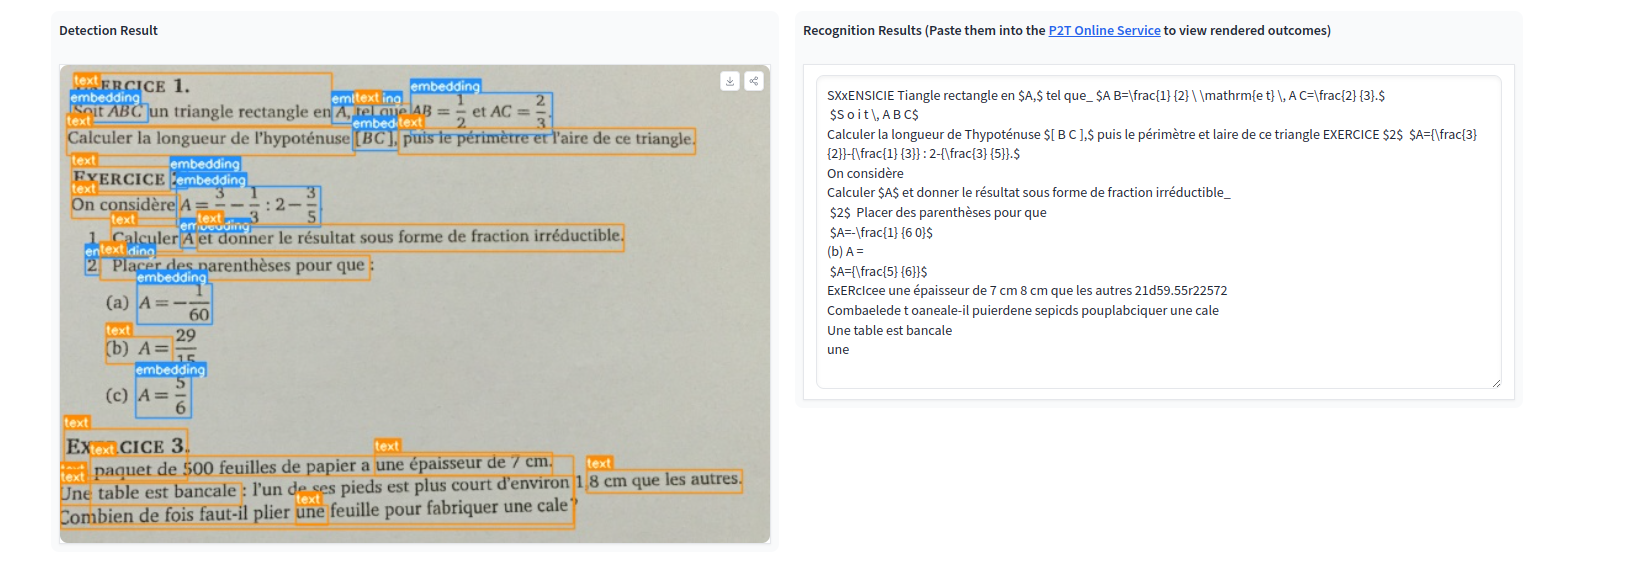

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

exempledm = "capture.png"
img = cv2.imread(exempledm)

cv2_imshow(img)